In [6]:
# Import libraries  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
import statsmodels.api as sm
# Tools for stationarity tests and VAR models
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
# To download financial data
import yfinance as yf 
# To evaluate forecast quality
from sklearn.metrics import mean_squared_error
# 1. Data Download 
# Download monthly data for BNP Paribas and VGK ETF between 2014 and 2019
bnp = yf.download('BNP.PA', start='2014-01-01', end='2019-12-31', interval='1mo')
vgk = yf.download('VGK', start='2014-01-01', end='2019-12-31', interval='1mo')
# Concatenate 'Close' columns of both series, aligning them on common dates
data = pd.concat([bnp['Close'], vgk['Close']], axis=1)
data.columns = ['BNP', 'VGK']
data = data.dropna()
# 2. Logarithmic transformation and return calculation
log_data = np.log(data)
# Calculate log returns: difference of logs
returns = log_data.diff().dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
# 3. ADF Stationarity Test
# Function to perform ADF test and print results
def run_adf(series, name):
    result = adfuller(series)
    print(f"\nADF Test for {name}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Conclusion:", "Stationary" if result[1] < 0.05 else "Non-stationary")

In [8]:
# 4. VAR Model Estimation  
# Create a VAR model from log returns
model = VAR(returns)
# Estimate model with 2 lags (order p=2)
results = model.fit(2)
# Display VAR model summary
print("\nVAR Model Summary:")
print(results.summary())


VAR Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 23, Dec, 2025
Time:                     00:11:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.5606
Nobs:                     69.0000    HQIC:                  -11.7559
Log likelihood:           224.196    FPE:                6.90113e-06
AIC:                     -11.8843    Det(Omega_mle):     6.00005e-06
--------------------------------------------------------------------
Results for equation BNP
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.003385         0.009464            0.358           0.721
L1.BNP        -0.274995         0.154697           -1.778           0.075
L1.VGK         0.228193         0.313505            0.728           0.

c:\Users\YANIGOAT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [10]:
# 5. Forecasting with a 2-period horizon
# Use the last 2 observations for forecasting
forecast = results.forecast(returns.values[-2:], steps=2)

# Store results in a DataFrame for readability
forecast_df = pd.DataFrame(forecast, columns=['BNP_forecast', 'VGK_forecast'])
print("\nLog returns forecast (2 steps):")
print(forecast_df)


Log returns forecast (2 steps):
   BNP_forecast  VGK_forecast
0      0.001427     -0.002577
1     -0.001434      0.001636


In [18]:
# 6. Conversion to price levels
# Last observed prices
last_prices = data.iloc[-1]

# Accumulate forecasted returns to get log prices
predicted_log_returns = forecast_df.cumsum()

# Convert back to prices (exponential of log)
predicted_prices = last_prices.values * np.exp(predicted_log_returns.values)
# Display forecasted prices
print("\nForecasted Prices:")
print(pd.DataFrame(predicted_prices, columns=data.columns))


Forecasted Prices:
         BNP        VGK
0  37.397511  47.849202
1  37.343933  47.927554


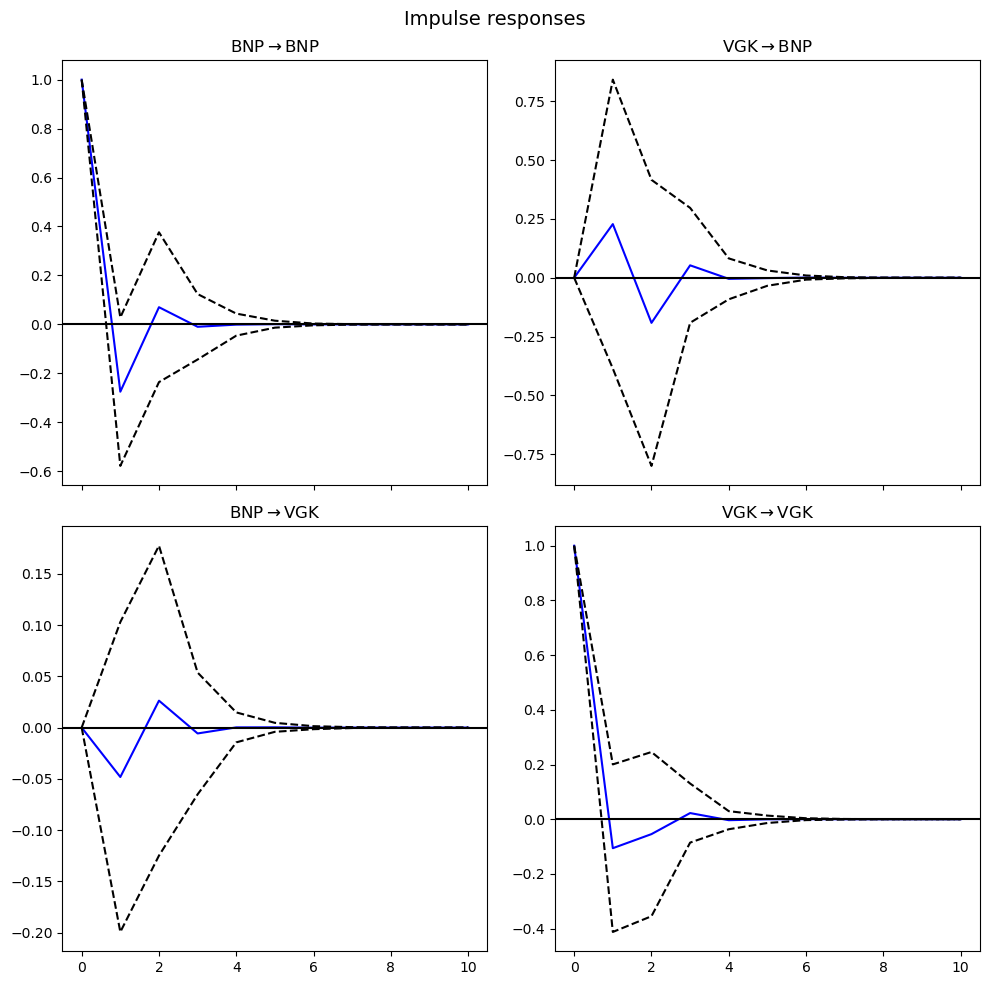

In [16]:
# 7. Impulse Response Functions (IRF)
# Calculate IRFs over 10 periods
irf = results.irf(10)

# Plot IRFs
irf.plot(orth=False)
plt.tight_layout()
plt.show()